## 1. Импорт всех необходимых библиотек для работы в проекте


In [2]:
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", None)
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

plt.rcParams["figure.dpi"] = 100
plt.style.use("ggplot")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "{:.2f}".format(x))
pd.reset_option("display.float_format")
# from category_encoders import TargetEncoder

# Важная настройка для корректной настройки pipeline!
import sklearn

sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    OrdinalEncoder,
    FunctionTransformer,
)
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import f_regression, chi2

# for model learning
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_val_score,
    StratifiedKFold,
)

# models
from sklearn.neighbors import (
    KNeighborsClassifier,
    RadiusNeighborsClassifier,
    KNeighborsRegressor,
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    BaggingClassifier,
    RandomForestRegressor,
    VotingRegressor,
)

# LightGBM
import lightgbm as lgb

# CatBoost
from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import accuracy_score, roc_auc_score

import seaborn as sns

# tunning hyperparamters model
import optuna

## 2. Обработка dataset


### 2.1 Работаем c предподготовкой датасета


In [10]:
# Читаем датасет
main_data = pd.read_csv("./datasets/train.csv")
main_data_copy = main_data.copy().set_index("Id")
main_data_copy.drop("3SsnPorch", axis=1, inplace=True)
main_data_copy["SalePrice"] = np.log(main_data_copy["SalePrice"])


In [40]:
q025 = main_data_copy["SalePrice"].quantile(0.025)
q975 = main_data_copy["SalePrice"].quantile(0.975)

In [ ]:
main_data_copy = main_data_copy[(main_data_copy["SalePrice"] > q025) &
                                (main_data_copy["SalePrice"] < q975)]

In [12]:
real_test = pd.read_csv("./datasets/test.csv")
real_test = real_test.copy().set_index("Id")
real_test.drop("3SsnPorch", axis=1, inplace=True)
real_test.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [13]:
def analitic_for_dataset(df):
    # делим датасет по типам данных
    df_numbers = df.select_dtypes(exclude="object")
    df_ctgrs = df.select_dtypes("object")

    # строим анализ датасета с числовыми признаками

    df_numbers_analitic = (
        pd.DataFrame(
            {
                "All_features": df_numbers.columns,
                "feature_type": df_numbers.dtypes,
                "empty_spaces": df_numbers.isna().sum(),
                "number_values": len(df_numbers),
                "unique_numbers": df_numbers.nunique(),
                "mean": df_numbers.mean(),
                "median": df_numbers.median(),
                "min": df_numbers.min(),
                "0.025": df_numbers.quantile(0.025),
                "0.975": df_numbers.quantile(0.975),
                "max": df_numbers.max(),
            }
        )
        .sort_values("unique_numbers")
        .reset_index(drop=True)
    )

    # строим анализ датасета с категориальными признаками

    modes = df_ctgrs.mode().iloc[0]

    count_mode = pd.Series(
        {col: (df_ctgrs[col] == modes[col]).sum() for col in df_ctgrs.columns}
    )

    df_ctgrs_analitic = (
        pd.DataFrame(
            {
                "All_features": df_ctgrs.columns,
                "feature_type": df_ctgrs.dtypes,
                "empty_spaces": df_ctgrs.isna().sum(),
                "number_values": len(df_ctgrs),
                "unique_numbers": df_ctgrs.nunique(),
                "mode": modes,
                "count_mode": count_mode,
            }
        )
        .sort_values("unique_numbers")
        .reset_index(drop=True)
    )

    return df_numbers_analitic, df_ctgrs_analitic, df_numbers, df_ctgrs

In [14]:
analitic_for_dataset(main_data_copy)[0]

,All_features,feature_type,empty_spaces,number_values,unique_numbers,mean,median,min,0.025,0.975,max
0,HalfBath,int64,0,1384,3,0.382948,0.000000,0.000000,0.000000,1.000000,2.00000
1,BsmtHalfBath,int64,0,1384,3,0.059249,0.000000,0.000000,0.000000,1.000000,2.00000
2,FullBath,int64,0,1384,4,1.565029,2.000000,0.000000,1.000000,2.000000,3.00000
3,BsmtFullBath,int64,0,1384,4,0.422688,0.000000,0.000000,0.000000,1.000000,3.00000
4,Fireplaces,int64,0,1384,4,0.611994,1.000000,0.000000,0.000000,2.000000,3.00000
5,KitchenAbvGr,int64,0,1384,4,1.048410,1.000000,0.000000,1.000000,2.000000,3.00000
6,GarageCars,int64,0,1384,5,1.765896,2.000000,0.000000,0.000000,3.000000,4.00000
7,YrSold,int64,0,1384,5,2007.799855,2008.000000,2006.000000,2006.000000,2010.000000,2010.00000
8,PoolArea,int64,0,1384,7,2.509393,0.000000,0.000000,0.000000,0.000000,738.00000
9,OverallQual,int64,0,1384,8,6.082370,6.000000,3.000000,4.000000,9.000000,10.00000


In [ ]:
# где очень много пропусков у категориальных признаков, заполняем "Unknown" (фильтруем)

column_drop_ctgrs = list(
    analitic_for_dataset(main_data_copy)[3].columns[
        analitic_for_dataset(main_data_copy)[3].isna().sum() >= 100
    ]
)
print(column_drop_ctgrs)

['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [16]:
# Удаляем ненужные колонки с основного датасета
main_data_copy.drop(
    column_drop_ctgrs
    + [
        "HalfBath",
        "Electrical",
        "Neighborhood",
        "BedroomAbvGr",
        "RoofStyle",
        "MSZoning",
        "GarageQual",
        "Exterior2nd",
        "LotConfig",
        "Condition2",
    ],
    inplace=True,
    axis=1,
)

In [17]:
# где очень много пропусков у категориальных признаков, заполняем "Unknown" (фильтруем)
# для тестовой выборки
column_drop_ctgrs = list(
    analitic_for_dataset(real_test)[3].columns[
        analitic_for_dataset(real_test)[3].isna().sum() >= 100
    ]
)
print(column_drop_ctgrs)

['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [18]:
# Удаляем ненужные колонки из тестовой выборки
real_test.drop(
    column_drop_ctgrs
    + [
        "HalfBath",
        "Electrical",
        "Neighborhood",
        "BedroomAbvGr",
        "RoofStyle",
        "MSZoning",
        "GarageQual",
        "Exterior2nd",
        "LotConfig",
        "Condition2",
    ],
    inplace=True,
    axis=1,
)

### 2.2 Готовим трансформеры для признаков(характеристик)


In [19]:
cutter_quants_list = [
    "LotFrontage",
    "EnclosedPorch",
    "BsmtFinSF2",
    "OpenPorchSF",
    "WoodDeckSF",
    "MasVnrArea",
    "2ndFlrSF",
    "GarageArea",
    "BsmtFinSF1",
    "TotalBsmtSF",
    "1stFlrSF",
    "BsmtUnfSF",
    "GrLivArea",
    "LotArea",
]

In [20]:
def cutter_quants(X):
    X_copy = X.copy()
    for col in cutter_quants_list:
        q_low = X_copy[col].quantile(0.025)
        q_high = X_copy[col].quantile(0.975)
        X_copy[col] = np.clip(X_copy[col], q_low, q_high)
    return X_copy

In [21]:
# Категориальные признаки 2 + (числовые итоговые)
my_inputer = ColumnTransformer(
    [
        (
            "all_num",
            SimpleImputer(strategy="median"),
            [
                "LotFrontage",
                "MasVnrArea",
                "BsmtHalfBath",
                "BsmtFullBath",
                "GarageCars",
                "GarageYrBlt",
                "BsmtFinSF2",
                "GarageArea",
                "BsmtFinSF1",
                "TotalBsmtSF",
                "BsmtUnfSF",
            ],
        ),
        (
            "all_ctgrs",
            SimpleImputer(strategy="most_frequent"),
            [
                "GarageFinish",
                "BsmtCond",
                "BsmtQual",
                "BsmtExposure",
                "GarageCond",
                "BsmtFinType1",
                "BsmtFinType2",
                "GarageType",
                "Utilities",
                "KitchenQual",
                "Functional",
                "SaleType",
                "Exterior1st",
            ],
        ),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

my_cutter = ColumnTransformer(
    [("cutter", FunctionTransformer(cutter_quants), cutter_quants_list)],
    verbose_feature_names_out=False,
    remainder="passthrough",
)


ordinal = [
    "BsmtHalfBath",
    "BsmtFullBath",
    "FullBath",
    "Fireplaces",
    "KitchenAbvGr",
    "GarageCars",
    "OverallCond",
    "OverallQual",
    "MoSold",
    "TotRmsAbvGrd",
    "MSSubClass",
    "GarageYrBlt",
    "YearRemodAdd",
    "YrSold",
    "Street",
    "Utilities",
    "CentralAir",
    "LandSlope",
    "GarageFinish",
    "PavedDrive",
    "LandContour",
    "ExterQual",
    "KitchenQual",
    "BsmtQual",
    "BsmtExposure",
    "BsmtCond",
    "LotShape",
    "HeatingQC",
    "ExterCond",
    "GarageCond",
    "BldgType",
    "Heating",
    "BsmtFinType1",
    "BsmtFinType2",
    "Foundation",
    "GarageType",
    "SaleCondition",
    "Functional",
    "HouseStyle",
    "RoofMatl",
    "SaleType",
    "Condition1",
    "Exterior1st",
]

standart_sc = ["LotFrontage", "GrLivArea", "1stFlrSF", "LotArea", "YearBuilt"]

minmax = [
    "PoolArea",
    "MiscVal",
    "LowQualFinSF",
    "ScreenPorch",
    "EnclosedPorch",
    "BsmtFinSF2",
    "OpenPorchSF",
    "WoodDeckSF",
    "MasVnrArea",
    "2ndFlrSF",
    "GarageArea",
    "BsmtFinSF1",
    "TotalBsmtSF",
    "BsmtUnfSF",
]

In [22]:
my_scaler_and_encoder = ColumnTransformer(
    [
        (
            "ordinal",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            ordinal,
        ),
        ("standart_sc", StandardScaler(), standart_sc),
        ("minmax", MinMaxScaler(), minmax),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

In [23]:
preprocessor = Pipeline(
    [
        ("inputering", my_inputer),
        ("cuttering", my_cutter),
        ("scaling", my_scaler_and_encoder),
    ]
)

In [24]:
X, y = main_data_copy.drop("SalePrice", axis=True), main_data_copy["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

In [25]:
# correlation
prec_df = preprocessor.fit_transform(main_data_copy)
prec_df["SalePrice"] = main_data_copy["SalePrice"]

corr_data = pd.DataFrame(
    prec_df.corr()["SalePrice"][:-1].sort_values(key=lambda x: abs(x), ascending=False)
)

<Axes: >

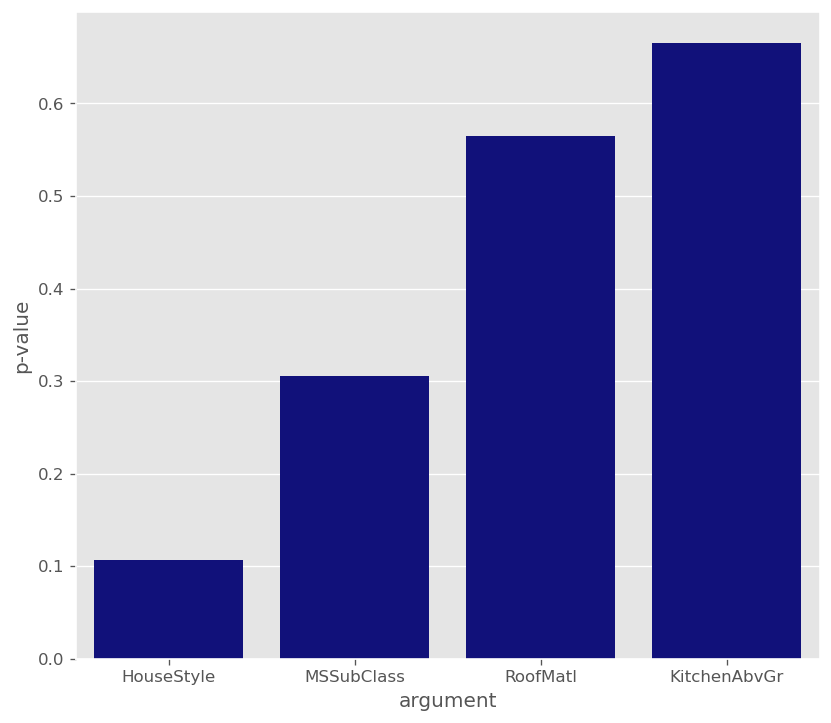

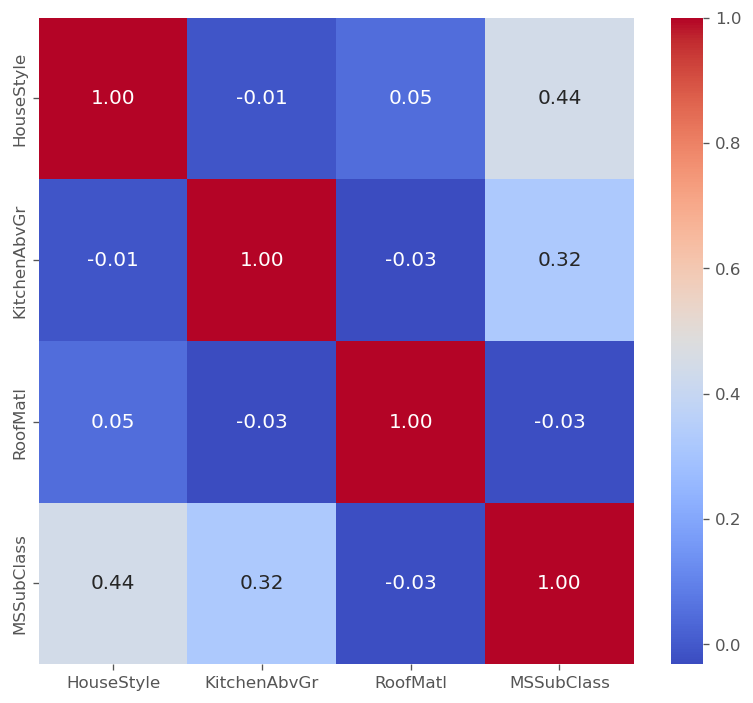

In [26]:
# p-value
p_val_data = pd.Series(
    dict(
        zip(X.columns, f_regression(prec_df.drop(columns="SalePrice"), prec_df["SalePrice"])[1],
        ))).sort_values()

cr_dt = corr_data.merge(p_val_data.to_frame(name='p_value'), left_index=True, right_index=True)
drop_list = cr_dt[(cr_dt['p_value'] > 0.05) & (abs(cr_dt['SalePrice']) < 0.3)].index.to_list()

pval_df = p_val_data.reset_index()
pval_df = pval_df.rename(columns={'index': 'argument', 0: 'p-value'})
pval_df = pval_df[pval_df['argument'].isin(drop_list)]

plt.figure(figsize=(8, 7), dpi=120)
sns.barplot(x=pval_df['argument'], y=pval_df['p-value'], color='darkblue')

plt.figure(figsize=(8, 7), dpi=120)
sns.heatmap(prec_df[drop_list].corr(), fmt=".2f", cmap="coolwarm", annot=True, annot_kws={"size": 12})

#### Прогоняем Optune для DecisionTreeRegressor


In [27]:
def objective(trial):
    # Гиперпараметры модели
    max_depth = trial.suggest_int("max_depth", 5, 15)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 7)
    criterion = trial.suggest_categorical(
        "criterion", ["squared_error", "friedman_mse", "absolute_error", "poisson"]
    )

    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42,
    )

    # Трансформер
    ml_pipeline = Pipeline(
        [
            ("inputering", my_inputer),
            ("cuttering", my_cutter),
            ("scaling", my_scaler_and_encoder),
            ("model", model),
        ]
    )

    trained_model = ml_pipeline.fit(X_train, y_train)
    y_test_proba = trained_model.predict(X_test)
    return root_mean_squared_error(y_test, y_test_proba)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-07-06 18:58:22,206] A new study created in memory with name: no-name-c4b61086-4d3e-4d21-9bd2-f9fbd2c632ac
[I 2025-07-06 18:58:22,280] Trial 0 finished with value: 0.15780977799335996 and parameters: {'max_depth': 6, 'min_samples_leaf': 5, 'criterion': 'poisson'}. Best is trial 0 with value: 0.15780977799335996.
[I 2025-07-06 18:58:22,432] Trial 1 finished with value: 0.1741723354345213 and parameters: {'max_depth': 12, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}. Best is trial 0 with value: 0.15780977799335996.
[I 2025-07-06 18:58:22,501] Trial 2 finished with value: 0.17156660611798027 and parameters: {'max_depth': 14, 'min_samples_leaf': 4, 'criterion': 'poisson'}. Best is trial 0 with value: 0.15780977799335996.
[I 2025-07-06 18:58:22,567] Trial 3 finished with value: 0.1793096801459624 and parameters: {'max_depth': 6, 'min_samples_leaf': 3, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 0.15780977799335996.
[I 2025-07-06 18:58:22,638] Trial 4 finished w

In [28]:
print(study.best_params)
print(np.expm1(study.best_value) * 100)

{'max_depth': 6, 'min_samples_leaf': 5, 'criterion': 'poisson'}
17.094343431163967


#### Прогоняем Optune для KNeighborsRegressor


In [ ]:
def objective(trial):
    # Гиперпараметры модели
    n_neighbors = trial.suggest_int("n_neighbors", 1, 50)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    p = trial.suggest_int("p", 1, 2)
    metric = trial.suggest_categorical(
        "metric", ["minkowski", "chebyshev", "manhattan", "euclidean"]
    )

    model = KNeighborsRegressor(
        n_neighbors=n_neighbors, weights=weights, p=p, metric=metric
    )

    # Трансформер
    ml_pipeline = Pipeline(
        [
            ("inputering", my_inputer),
            ("cuttering", my_cutter),
            ("scaling", my_scaler_and_encoder),
            ("model", model),
        ]
    )

    trained_model = ml_pipeline.fit(X_train, y_train)
    y_test_proba = trained_model.predict(X_test)
    return root_mean_squared_error(y_test, y_test_proba)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2025-07-06 18:58:44,009] A new study created in memory with name: no-name-5a5a2e21-9578-4420-9ede-54b080366799
[I 2025-07-06 18:58:44,097] Trial 0 finished with value: 0.2347684706858929 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 2, 'metric': 'chebyshev'}. Best is trial 0 with value: 0.2347684706858929.
[I 2025-07-06 18:58:44,168] Trial 1 finished with value: 0.17540396783359177 and parameters: {'n_neighbors': 31, 'weights': 'distance', 'p': 1, 'metric': 'minkowski'}. Best is trial 1 with value: 0.17540396783359177.
[I 2025-07-06 18:58:44,236] Trial 2 finished with value: 0.16425419985442083 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'p': 2, 'metric': 'manhattan'}. Best is trial 2 with value: 0.16425419985442083.
[I 2025-07-06 18:58:44,300] Trial 3 finished with value: 0.16860207783989073 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'p': 2, 'metric': 'manhattan'}. Best is trial 2 with value: 0.16425419985442083.
[I 2025-07-06 18:58:44

In [30]:
print(study.best_params)
print(np.expm1(study.best_value) * 100)

{'n_neighbors': 6, 'weights': 'distance', 'p': 1, 'metric': 'manhattan'}
17.380592796074982


#### Прогоняем Optune для RandomForestRegressor


In [31]:
def objective(trial):
    # Гиперпараметры модели
    max_depth = trial.suggest_int("max_depth", 5, 15)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 7)
    criterion = trial.suggest_categorical(
        "criterion", ["squared_error", "friedman_mse", "absolute_error", "poisson"]
    )

    model = RandomForestRegressor(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42,
        n_estimators=100,
    )

    # Трансформер
    ml_pipeline = Pipeline(
        [
            ("inputering", my_inputer),
            ("cuttering", my_cutter),
            ("scaling", my_scaler_and_encoder),
            ("model", model),
        ]
    )

    trained_model = ml_pipeline.fit(X_train, y_train)
    y_test_proba = trained_model.predict(X_test)
    return root_mean_squared_error(y_test, y_test_proba)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2025-07-06 18:59:03,686] A new study created in memory with name: no-name-828ab8e1-fe03-4aea-b3c7-4aebe8257341
[I 2025-07-06 18:59:04,461] Trial 0 finished with value: 0.11875267493882198 and parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 0 with value: 0.11875267493882198.
[I 2025-07-06 18:59:05,114] Trial 1 finished with value: 0.12248415011862362 and parameters: {'max_depth': 14, 'min_samples_leaf': 5, 'criterion': 'squared_error'}. Best is trial 0 with value: 0.11875267493882198.
[I 2025-07-06 18:59:10,233] Trial 2 finished with value: 0.12846770392647933 and parameters: {'max_depth': 12, 'min_samples_leaf': 6, 'criterion': 'absolute_error'}. Best is trial 0 with value: 0.11875267493882198.
[I 2025-07-06 18:59:11,034] Trial 3 finished with value: 0.11828680665079477 and parameters: {'max_depth': 12, 'min_samples_leaf': 2, 'criterion': 'friedman_mse'}. Best is trial 3 with value: 0.11828680665079477.
[I 2025-07-06 18:59:11,597] Tr

In [32]:
print(study.best_params)
print(np.expm1(study.best_value) * 100)

{'max_depth': 13, 'min_samples_leaf': 2, 'criterion': 'squared_error'}
12.52446463122356


#### Прогоняем Optune для CatBoostRegressor


In [34]:
def objective(trial):
    params = {
        "iterations": 1000,
        "early_stopping_rounds": 50,
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1, 20),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]
        ),
        # 'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "verbose": 0,
        "loss_function": "RMSE",
        "random_state": 42,
    }

    model = CatBoostRegressor(**params)

    # Трансформер
    ml_pipeline = Pipeline(
        [
            ("inputering", my_inputer),
            ("cuttering", my_cutter),
            ("scaling", my_scaler_and_encoder),
            ("model", model),
        ]
    )

    trained_model = ml_pipeline.fit(X_train, y_train)
    y_test_proba = trained_model.predict(X_test)

    return root_mean_squared_error(y_test, y_test_proba)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-07-06 19:01:56,929] A new study created in memory with name: no-name-93d03e02-883e-40cb-afe6-f6db20a3593a
[I 2025-07-06 19:02:01,514] Trial 0 finished with value: 0.13782427276398038 and parameters: {'depth': 8, 'learning_rate': 0.002972970057873763, 'l2_leaf_reg': 4.17121543810638, 'bagging_temperature': 0.8132508770848057, 'border_count': 146, 'random_strength': 8.551688488028383, 'grow_policy': 'Depthwise', 'subsample': 0.8487188366418197}. Best is trial 0 with value: 0.13782427276398038.
[I 2025-07-06 19:02:09,050] Trial 1 finished with value: 0.12918834660977402 and parameters: {'depth': 10, 'learning_rate': 0.004595421815867912, 'l2_leaf_reg': 7.6537830552982, 'bagging_temperature': 0.1623101857025696, 'border_count': 32, 'random_strength': 8.522328917855734, 'grow_policy': 'Depthwise', 'subsample': 0.7907537119386187}. Best is trial 1 with value: 0.12918834660977402.
[I 2025-07-06 19:02:12,924] Trial 2 finished with value: 0.13271904334553783 and parameters: {'depth': 7,

In [35]:
print(study.best_params)
print(np.expm1(study.best_value) * 100)

{'depth': 5, 'learning_rate': 0.01934735955351261, 'l2_leaf_reg': 3.5013692451727, 'bagging_temperature': 0.4659006328161037, 'border_count': 211, 'random_strength': 2.3774011571476947, 'grow_policy': 'Lossguide', 'subsample': 0.8475144632481331}
9.742809303497134


#### ФИНАЛ ДЛЯ KAGGLE


In [36]:
lr = LinearRegression()

dt = DecisionTreeRegressor(
    max_depth=6, min_samples_leaf=6, criterion="poisson", random_state=42
)

knn = KNeighborsRegressor(n_neighbors=6, p=1, weights="distance", metric="manhattan")

rfr = RandomForestRegressor(
    n_estimators=100,
    max_depth=13,
    min_samples_leaf=2,
    criterion="squared_error",
)

cb = CatBoostRegressor(
    iterations=1000,
    early_stopping_rounds=50,
    depth=5,
    learning_rate=0.01934735955351261,
    l2_leaf_reg=3.5013692451727,
    bagging_temperature=0.4659006328161037,
    border_count=211,
    random_strength=2.3774011571476947,
    grow_policy="Lossguide",
    subsample=0.8475144632481331,
    verbose=0,
    loss_function="RMSE",
    random_state=42,
)


In [37]:
def objective(trial):
    # Гиперпараметры модели
    raw_weights = [trial.suggest_float(f'w{i}', 0.001, 1.0) for i in range(5)]
    weight_sum = sum(raw_weights)
    weights_dirichle = [w / weight_sum for w in raw_weights]

    voting = VotingRegressor(
        estimators=[("lr", lr), ("dt", dt), ("knn", knn), ("rfr", rfr), ("cb", cb)],
        weights=weights_dirichle,
    )

    pipe = Pipeline(
        [
            ('preprocessor', preprocessor),
            ('model', voting)
        ]

    )

    trained_model = pipe.fit(X_train, y_train)
    y_pred = trained_model.predict(X_test)

    return root_mean_squared_error(y_test, y_pred)  # RMSE


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-07-06 19:05:57,721] A new study created in memory with name: no-name-54621980-d0df-47c4-b375-5dc97fefd744
[I 2025-07-06 19:06:00,301] Trial 0 finished with value: 0.10762431036547224 and parameters: {'w0': 0.9480530399413806, 'w1': 0.7375692691501295, 'w2': 0.8261558225813789, 'w3': 0.05281336564296648, 'w4': 0.8711581946807132}. Best is trial 0 with value: 0.10762431036547224.
[I 2025-07-06 19:06:02,894] Trial 1 finished with value: 0.10968507545473709 and parameters: {'w0': 0.18039331260512428, 'w1': 0.45792230173917986, 'w2': 0.496580017948911, 'w3': 0.45172861654234897, 'w4': 0.7636540711886934}. Best is trial 0 with value: 0.10762431036547224.
[I 2025-07-06 19:06:05,417] Trial 2 finished with value: 0.11220502870131725 and parameters: {'w0': 0.09374807368020735, 'w1': 0.04075504406715267, 'w2': 0.7947947990900022, 'w3': 0.3560702100931733, 'w4': 0.7980219986585241}. Best is trial 0 with value: 0.10762431036547224.
[I 2025-07-06 19:06:07,918] Trial 3 finished with value: 0.

In [38]:
print(study.best_params)
print(np.expm1(study.best_value) * 100)

{'w0': 0.91326722014212, 'w1': 0.002410457493195184, 'w2': 0.042862204769547406, 'w3': 0.24918924056236008, 'w4': 0.9351686455353533}
9.928771661490785


In [41]:
voting = VotingRegressor(
        estimators=[("lr", lr), ("dt", dt), ("knn", knn), ("rfr", rfr), ("cb", cb)],
        weights=[0.91326722014212, 0.002410457493195184, 0.042862204769547406, 0.24918924056236008, 0.9351686455353533],
    )

pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', voting)
    ]
)

In [42]:
final_model = pipe.fit(X_train, y_train)

In [43]:
y_final = final_model.predict(real_test)
np.exp(y_final)


array([122325.07353864, 157900.73690389, 182162.0426084 , ...,
       160645.79299915, 122163.87996141, 238489.33209377], shape=(1459,))

In [44]:
final_csv = pd.DataFrame(np.exp(y_final), real_test.index).reset_index()
final_csv.columns = ["Id", "SalePrice"]
final_csv.to_csv("submission4.csv", index=False)